In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [33]:
# reflect an existing database into a new model
# Reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

# Create a session
session = Session(engine)

# reflect the tables


/var/folders/30/cjk36ztd21vb2_r5q9ks48nh0000gn/T/ipykernel_12557/650008662.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [34]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [35]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Print the most recent date
print(f"The most recent date in the dataset is: {most_recent_date[0]}")


The most recent date in the dataset is: 2017-08-23


One year ago from the most recent date: 2016-08-23 00:00:00


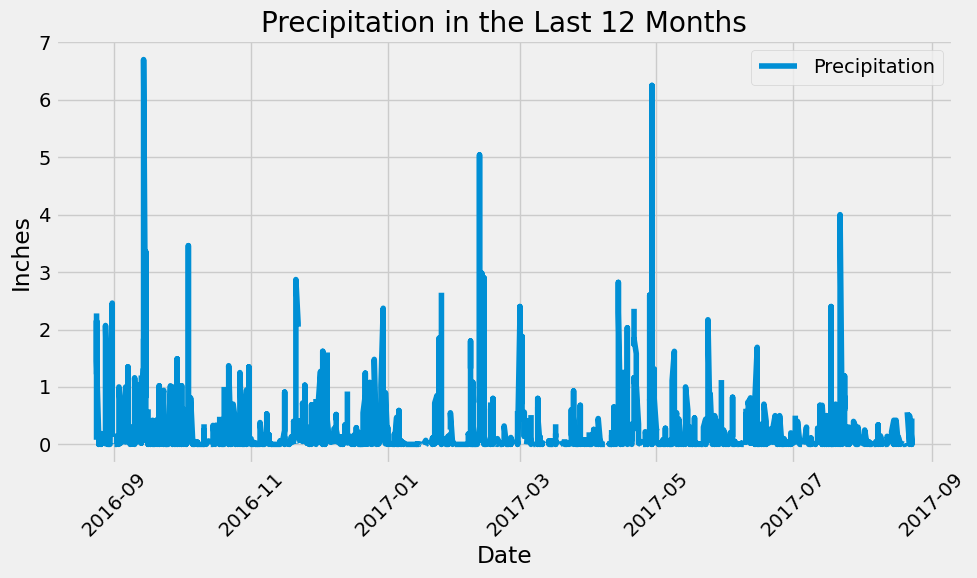

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in the dataset
import datetime as dt

# Assuming `most_recent_date` contains the most recent date from the previous step
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
print(f"One year ago from the most recent date: {one_year_ago}")


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()



# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Convert the date column to datetime format
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()




In [39]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Ensure the DataFrame column is correctly named 'precipitation'
precipitation_df.rename(columns={'Precipitation': 'precipitation'}, inplace=True)

# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()

# Display the summary statistics
print(precipitation_summary)


count   2015.000000
mean       0.176462
std        0.460288
min        0.000000
25%        0.000000
50%        0.020000
75%        0.130000
max        6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id).count()

# Print the total number of stations
print(f"Total number of stations in the dataset: {total_stations}")


Total number of stations in the dataset: 9


In [41]:
# Design a query to find the most active stations
# List the stations and their counts in descending order

from sqlalchemy import func

# Query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the results
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station id from the previous query
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Display the results
temperature_stats


[(54.0, 85.0, 71.66378066378067)]

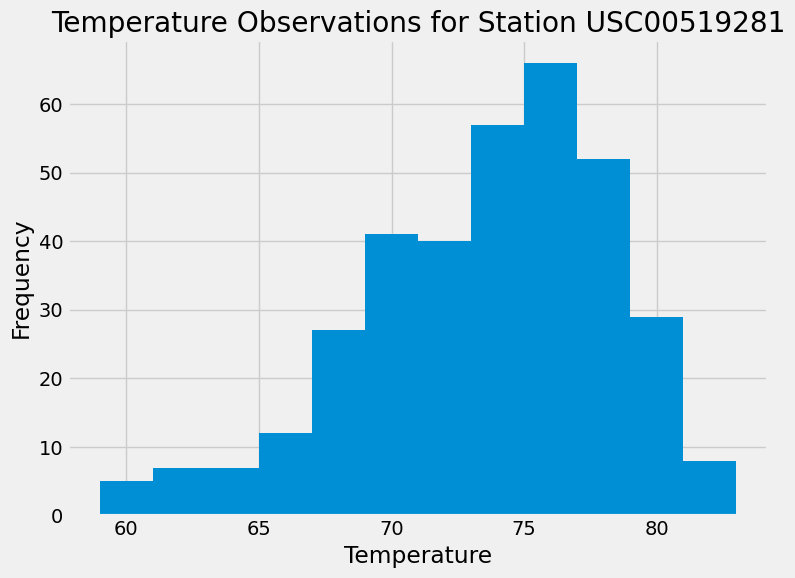

In [43]:
# Using the most active station id
# Calculate the date one year ago from the last date in the dataset
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_observations = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert to a list or array for easier plotting
temperature_data = [temp[0] for temp in temperature_observations]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_data, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station ' + most_active_station)
plt.tight_layout()
plt.show()




# Close Session

In [44]:
# Close Session
session.close()